In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from matplotlib import pyplot as plt

In [59]:
b_data = pd.read_csv("b_features_2.csv").dropna()
print(b_data.shape)
b_data

(423107, 15)


,eta_row_id,log_id,bus_id,stop_id,sort_order,eta_seconds,pred_eta_s,actual_arrival_ts,actual_travel_s,eta_error_s,pax_load,hour,time_of_day_s,speed_prev_mps,speed_1min_mps
0,9297746,1377283,4851,10065,0,97,97,2025-11-24 14:02:07,138.0,41.0,0.0,13,50389,6.469397,4.435918
1,9297747,1377283,4851,10034,1,769,769,2025-11-24 14:08:16,507.0,-262.0,0.0,13,50389,6.469397,4.435918
2,9297748,1377283,4851,10041,2,856,856,2025-11-24 14:09:35,586.0,-270.0,0.0,13,50389,6.469397,4.435918
3,9297749,1377283,4851,10052,3,960,960,2025-11-24 14:11:58,729.0,-231.0,0.0,13,50389,6.469397,4.435918
4,9297963,1377321,4851,10065,0,85,85,2025-11-24 14:02:07,126.0,41.0,13.0,14,50401,1.549333,3.578405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423102,5430731,929710,20285,10052,0,2,2,2025-11-15 03:29:32,61.0,59.0,5.0,3,12511,0.032448,0.039112
423103,5430840,929725,20285,10052,0,2,2,2025-11-15 03:29:32,51.0,49.0,5.0,3,12521,0.028549,0.040013
423104,5430949,929740,20285,10052,0,2,2,2025-11-15 03:29:32,42.0,40.0,5.0,3,12530,0.038000,0.051211
423105,5431064,929755,20285,10052,5,1066,1066,2025-11-15 03:29:32,31.0,-1035.0,5.0,3,12541,0.118400,0.171236


In [ ]:
def series_without_outliers(series, k=1.5):
    s = series.dropna()
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    return series.between(low, high) | series.isna()
b_data_no_outliers = b_data.copy()
eta_error_no_outliers = series_without_outliers(b_data_no_outliers["eta_error_s"], k=1.5)
speed_no_outliers = series_without_outliers(b_data_no_outliers["speed_prev_mps"], k=1.5)
b_data_no_outliers = b_data_no_outliers[eta_error_no_outliers & speed_no_outliers].reset_index(drop=True)
print(b_data_no_outliers.shape)

(393701, 15)


In [164]:
y = b_data_no_outliers["eta_error_s"]
X = b_data_no_outliers[["pred_eta_s", "speed_1min_mps"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y.shape)
print(X.shape)
print(y_train.shape)
print(X_train.shape)

(393701,)
(393701, 2)
(314960,)
(314960, 2)


In [149]:
mse_zero_baseline = mean_squared_error(y_test, np.zeros_like(y_test))
print(mse_zero_baseline)
print("The original ETA by Passio Go is on average", np.sqrt(mse_zero_baseline), "seconds off the actual arrival time.")

74236.13458045998
The original ETA by Passio Go is on average 272.463088473393 seconds off the actual arrival time.


In [150]:
mean_eta_error = np.mean(y_train)
print(mean_eta_error)

190.88690627381254


In [151]:
def baseline_model(X):
    return np.full(shape=(X.shape[0],), fill_value=mean_eta_error)

In [152]:
mse_baseline = mean_squared_error(y_test, baseline_model(X_test))
print(mse_baseline)
print("The baseline is on average", np.sqrt(mse_baseline), "seconds off the actual arrival time.")

37957.60031532696
The baseline is on average 194.8271036466101 seconds off the actual arrival time.


In [153]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("model:", model.coef_)
print("model intercept:", model.intercept_)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

model: [ 0.10335143 -9.04434065]
model intercept: 202.16348948995193
MSE: 35422.73827089899
RMSE: 188.20929379522943
R2: 0.06677712998396723


In [154]:
pipe_deg2 = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, include_bias=False), Ridge(alpha=100.0))
pipe_deg2.fit(X_train, y_train)
y_pred_deg2 = pipe_deg2.predict(X_test)
print("Degree 2 model coefficients:", pipe_deg2.named_steps['ridge'].coef_)
print("Degree 2 MSE:", mean_squared_error(y_test, y_pred_deg2))
print("Degree 2 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_deg2)))
print("Degree 2 R2:", r2_score(y_test, y_pred_deg2))

Degree 2 model coefficients: [ 58.65418375 -49.17213767 -38.80353016   8.91873371  13.80491981]
Degree 2 MSE: 32977.87180759347
Degree 2 RMSE: 181.59810518723336
Degree 2 R2: 0.13118788446158902


In [160]:
pipe_deg3 = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3, include_bias=False), Ridge(alpha=80.0))
pipe_deg3.fit(X_train, y_train)
y_pred_deg3 = pipe_deg3.predict(X_test)
print("Degree 3 model coefficients:", pipe_deg3.named_steps['ridge'].coef_)
print("Degree 3 MSE:", mean_squared_error(y_test, y_pred_deg3))
print("Degree 3 RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_deg3)))
print("Degree 3 R2:", r2_score(y_test, y_pred_deg3))

Degree 3 model coefficients: [ 58.44795006 -41.06475814 -44.35174397  12.01495958  20.09429948
   2.89092289  -0.25998796  -4.24075052  -4.43944551]
Degree 3 MSE: 32902.98276735398
Degree 3 RMSE: 181.39179355018786
Degree 3 R2: 0.13316085912352982


In [ ]:
df = b_data_no_outliers.copy() 
B_BUS_START_HOUR = 12 #We use UTC
B_BUS_OPERATION_HOURS = 16
t = (df["time_of_day_s"].astype(float) + 86400 - 60*60*B_BUS_START_HOUR) % (24*60*60)
frac = t / (B_BUS_OPERATION_HOURS*60*60)
df["sin_time"] = np.sin(2 * np.pi * frac)
df["cos_time"] = np.cos(2 * np.pi * frac)

X = df[["pred_eta_s", "speed_1min_mps", "sin_time", "cos_time"]].apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(df["eta_error_s"], errors="coerce")
valid = X.notna().all(axis=1) & y.notna()
X = X[valid].reset_index(drop=True)
y = y[valid].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Polynomial": make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), RidgeCV(alphas=np.logspace(-10,10,60))),
    "Polynomial_3": make_pipeline(StandardScaler(), PolynomialFeatures(degree=3), RidgeCV(alphas=np.logspace(-10,10,60)))}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    print(mdl.named_steps[list(mdl.named_steps.keys())[-1]].coef_)
    y_pred = mdl.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.3f} s, R2={r2:.4f}")

[ 32.09529944 -39.27107065  16.47391716 -21.24574759]
Linear: RMSE=186.394 s, R2=0.0847
[  0.          61.37135989 -47.21661422  14.24149101 -18.56577003
 -35.37937606   9.58089938   2.09789186  -8.91945599  13.52391388
  -3.05251648   0.5052123    8.50077316  11.10134324 -14.55155159]
Polynomial: RMSE=178.908 s, R2=0.1567
[ 0.00000000e+00  2.14044828e+01 -1.31827362e+01  6.81566888e+00
 -7.59501416e+00 -4.06966502e+01  1.27085933e+01  6.71161382e+00
 -1.26996490e+01  1.99381870e+01 -5.94887086e+00  2.36415336e+00
  9.52222195e+00  8.04200945e+00 -1.28909496e+01  2.84274648e+00
 -2.82765156e-01 -1.37525531e-01  2.09927129e+00 -4.11929038e+00
  4.19756910e+00  1.35134542e+00  2.67192007e+01  3.91136183e+00
  1.25046142e+01 -4.63044067e+00  2.15792352e+00 -1.09880433e-03
 -1.40769124e+01 -3.71393003e+00 -1.08677573e+01 -1.13807851e+00
 -1.33347764e+01  1.53538644e+01 -4.34548734e+00]
Polynomial_3: RMSE=177.992 s, R2=0.1654


In [ ]:
def print_linear_equation(model, feature_names):
    if hasattr(model, "named_steps") and "linearregression" in model.named_steps:
        lr = model.named_steps["linearregression"]
        coef_z = lr.coef_.ravel()
        intercept = float(lr.intercept_)
        coefs = coef_z
    elif isinstance(model, (LinearRegression, Ridge, RidgeCV)):
        coefs = model.coef_.ravel()
        intercept = float(model.intercept_)
    else:
        print("Model different from expected")
    terms = [f"{coefs[i]:+.6g}*{feature_names[i]}" for i in range(len(feature_names))]
    eq = f"y = {intercept:.6g} " + " ".join(terms)
    print(eq)
    
def print_polynomial_equation(poly_pipeline, original_feature_names):
    poly = poly_pipeline.named_steps["polynomialfeatures"]
    ridge = poly_pipeline.named_steps[list(poly_pipeline.named_steps.keys())[-1]]
    feature_names = poly.get_feature_names_out(original_feature_names)
    coefs = ridge.coef_.ravel()
    intercept = float(ridge.intercept_)
    terms = []
    for c, name in zip(coefs, feature_names):
        if abs(c) < 1e-9:
            continue
        terms.append(f"{c:+.6g}*({name})")
    eq = f"y = {intercept:.6g} " + " ".join(terms)
    print(eq)

In [185]:
print_linear_equation(models["Linear"], X.columns)
print_polynomial_equation(models["Polynomial"], X.columns)

y = 190.887 +32.0953pred_eta_s -39.2711speed_1min_mps +16.4739sin_time -21.2457cos_time
y = 219.34 +61.3714*(pred_eta_s) -47.2166*(speed_1min_mps) +14.2415*(sin_time) -18.5658*(cos_time) -35.3794*(pred_eta_s^2) +9.5809*(pred_eta_s speed_1min_mps) +2.09789*(pred_eta_s sin_time) -8.91946*(pred_eta_s cos_time) +13.5239*(speed_1min_mps^2) -3.05252*(speed_1min_mps sin_time) +0.505212*(speed_1min_mps cos_time) +8.50077*(sin_time^2) +11.1013*(sin_time cos_time) -14.5516*(cos_time^2)


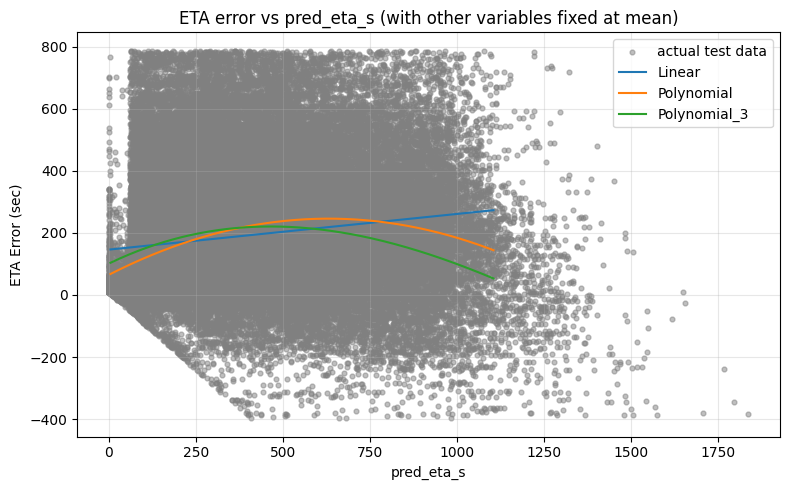

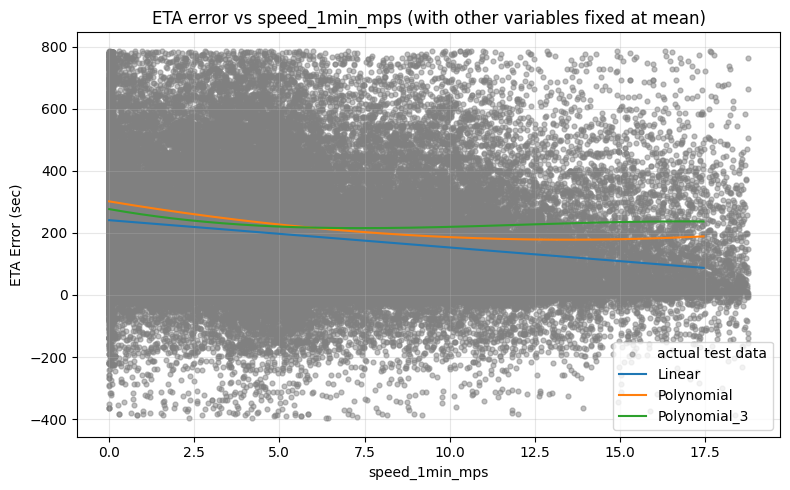

In [ ]:
def plot_feature_fit(models, X_train, X_test, y_train, y_test, feature='pred_eta_s', n_grid=300):
    lo = X[feature].quantile(0.01)
    hi = X[feature].quantile(0.99)
    x_grid = np.linspace(lo, hi, n_grid)
    means = X_train.mean()

    plt.figure(figsize=(8, 5))
    plt.scatter(X_test[feature], y_test, s=12, alpha=0.5, color='gray', label='actual test data')

    for name, mdl in models.items():
        grid_df = pd.DataFrame({c: means[c] for c in X_train.columns}, index=range(n_grid))
        grid_df[feature] = x_grid
        y_pred_grid = mdl.predict(grid_df)
        plt.plot(x_grid, y_pred_grid, label=name)

    plt.xlabel(feature)
    plt.ylabel('ETA Error (sec)')
    plt.title(f'ETA error vs {feature} (with other variables fixed at mean)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_feature_fit(models, X_train, X_test, y_train, y_test, feature='pred_eta_s')
plot_feature_fit(models, X_train, X_test, y_train, y_test, feature='speed_1min_mps')

We're plotting a histogram for the time results and seeing how well our models fit with the histogram. The historgram is used for the time because the relationship is hard to see with it not being linear.

/var/folders/j7/zg72qj2521b4v_sw10nk4ntm0000gn/T/ipykernel_16869/273461676.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_eta = binned.groupby('bin')['eta'].mean().astype(float)


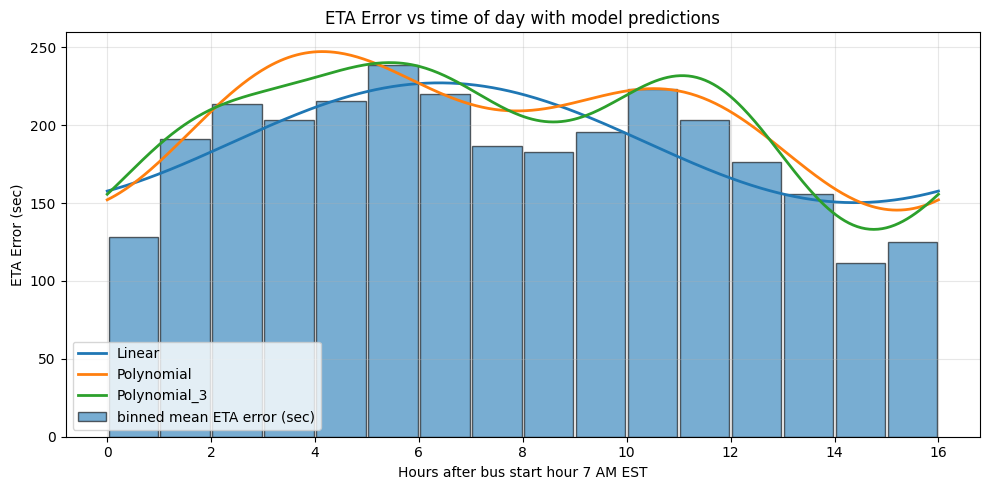

In [ ]:
def plot_histogram_with_model(models, df, X, y, B_BUS_START_HOUR=12, B_BUS_OPERATION_HOURS=16,
                     n_bins=None, n_grid=400):
    t = (df["time_of_day_s"].astype(float) + 86400 - 60*60*B_BUS_START_HOUR) % (24*60*60)
    operation_seconds = B_BUS_OPERATION_HOURS * 3600
    t_op = t[(t >= 0) & (t < operation_seconds)].astype(float)
    y_op = y[(t >= 0) & (t < operation_seconds)].astype(float)

    if n_bins is None:
        n_bins = B_BUS_OPERATION_HOURS
    bins = np.linspace(0, operation_seconds, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2.0
    binned = pd.DataFrame({'t': t_op.values, 'eta': y_op.values})
    binned['bin'] = pd.cut(binned['t'], bins=bins, labels=bin_centers, include_lowest=True, right=False)
    agg_eta = binned.groupby('bin')['eta'].mean().astype(float)

    time_grid = np.linspace(0, operation_seconds, n_grid)
    frac = time_grid / (operation_seconds)
    sin_time = np.sin(2 * np.pi * frac)
    cos_time = np.cos(2 * np.pi * frac)

    #Finding the median so we know where we need to plot middle of bars
    feature_meds = X.median()
    grid_df = pd.DataFrame({c: feature_meds[c] for c in X.columns}, index=range(n_grid))
    if 'sin_time' in grid_df.columns:
        grid_df['sin_time'] = sin_time
    else:
        grid_df.insert(len(grid_df.columns), 'sin_time', sin_time)
    if 'cos_time' in grid_df.columns:
        grid_df['cos_time'] = cos_time
    else:
        grid_df.insert(len(grid_df.columns), 'cos_time', cos_time)

    plt.figure(figsize=(10, 5))
    width_hours = (bins[1] - bins[0]) / 3600
    xs_hours = bin_centers / 3600
    plt.bar(xs_hours, agg_eta.values, width=width_hours * 0.95, align='center', alpha=0.6, edgecolor='k',
            label=f'binned mean ETA error (sec)')

    hours_grid = time_grid / 3600
    for name, mdl in models.items():
        try:
            y_pred_grid = mdl.predict(grid_df)
        except Exception:
            y_pred_grid = mdl.predict(grid_df[X.columns])
        plt.plot(hours_grid, y_pred_grid, lw=2, label=name)

    plt.xlabel(f'Hours after bus start hour {B_BUS_START_HOUR - 5} AM EST')
    plt.ylabel('ETA Error (sec)')
    plt.title('ETA Error vs time of day with model predictions')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

#Now we're plotting the results for the B bus route
plot_histogram_with_model(models, df, X, y, B_BUS_START_HOUR=12, B_BUS_OPERATION_HOURS=16, n_bins=16)